In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import torch
from datetime import datetime, timedelta
from typing import List, Tuple, Union, Dict
import time

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from darts import TimeSeries
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.dataprocessing.transformers.scaler import Scaler
from darts.models import TiDEModel, NaiveMovingAverage, TFTModel
from darts.metrics import mae, mse, smape
from darts.utils.losses import MAELoss, MapeLoss, SmapeLoss
import darts

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

c:\Users\tjqtj\miniconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_global_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # CuDNN 연산을 deterministic하게 만들어 주지만, 약간 느려질 수 있음
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 값 고정
set_global_seed()

In [3]:
def to_darts_time_series_group(
    dataset: pd.DataFrame,
    target: Union[List[str],str],
    time_col: str,
    group_cols: Union[List[str],str],
    static_cols: Union[List[str],str]=None,
    past_cols: Union[List[str],str]=None,
    future_cols: Union[List[str],str]=None,
    freq: str=None,
    encode_static_cov: bool=True,
)-> Tuple[List[TimeSeries], List[TimeSeries], List[TimeSeries], List[TimeSeries]]:

    series_raw = TimeSeries.from_group_dataframe(
    dataset,
    time_col    =   time_col,
    group_cols  =   group_cols,  # individual time series are extracted by grouping `df` by `group_cols`
    static_cols =   static_cols,  # also extract these additional columns as static covariates (without grouping)
    value_cols  =   target,  # optionally, specify the time varying columns
    n_jobs      =   -1,
    verbose     =   False,
    freq        =   freq,
    )

    if encode_static_cov:
        static_cov_transformer = StaticCovariatesTransformer()
        series_encoded = static_cov_transformer.fit_transform(series_raw)
    else: series_encoded = []

    if past_cols:
        past_cov = TimeSeries.from_group_dataframe(
            dataset,
            time_col    =   time_col,
            group_cols  =   group_cols,
            value_cols  =   past_cols,
            n_jobs      =   -1,
            verbose     =   False,
            freq        =   freq,
            )
    else: past_cov = []

    if future_cols:
        future_cov = TimeSeries.from_group_dataframe(
            dataset,
            time_col    =   time_col,
            group_cols  =   group_cols,
            value_cols  =   future_cols,
            n_jobs      =   -1,
            verbose     =   False,
            freq        =   freq,
            )
    else: future_cov = []

    return series_raw, series_encoded, past_cov, future_cov

def split_grouped_darts_time_series(
    series: List[TimeSeries],
    split_date: Union[str, pd.Timestamp],
    min_date: Union[str, pd.Timestamp]=None,
    max_date: Union[str, pd.Timestamp]=None,
) -> Tuple[List[TimeSeries], List[TimeSeries]]:

    if min_date:
       raw_series = series.copy()
       series = []
       for s in raw_series:
        try: series.append(s.split_before(pd.Timestamp(min_date)-timedelta(1))[1])
        except: series.append(s)

    if max_date:
       raw_series = series.copy()
       series = []
       for s in raw_series:
        try: series.append(s.split_before(pd.Timestamp(max_date))[0])
        except: series.append(s)

    split_0 = [s.split_before(pd.Timestamp(split_date))[0] for s in series]
    split_1 = [s.split_before(pd.Timestamp(split_date))[1] for s in series]
    return split_0, split_1

def eval_forecasts(
    pred_series: Union[List[TimeSeries], TimeSeries],
    test_series: Union[List[TimeSeries], TimeSeries],
    error_metric: darts.metrics,
    plot: bool=False
) -> List[float]:

    errors = error_metric(test_series, pred_series)
    print(errors)
    if plot:
        plt.figure()
        plt.hist(errors, bins=50)
        plt.ylabel("Count")
        plt.xlabel("Error")
        plt.title(f"Mean error: {np.mean(errors):.3f}")
        plt.show()
        plt.close()
    return errors

def fit_mixed_covariates_model(
    model_cls,
    common_model_args: dict,
    specific_model_args: dict,
    model_name: str,
    past_cov: Union[List[TimeSeries], TimeSeries],
    future_cov: Union[List[TimeSeries], TimeSeries],
    train_series: Union[List[TimeSeries], TimeSeries],
    val_series: Union[List[TimeSeries], TimeSeries]=None,
    max_samples_per_ts: int=None,
    save:bool=False,
    path:str="",
):

    # Declarare model
    model = model_cls(model_name=model_name,
                    **common_model_args,
                    **specific_model_args)

    # Train model
    model.fit(
                    # TRAIN ARGS ===================================
                    series                = train_series,
                    past_covariates       = past_cov,
                    future_covariates     = future_cov,
                    max_samples_per_ts    = max_samples_per_ts,
                    # VAL ARGS ======================================
                    val_series            = val_series,
                    val_past_covariates   = past_cov,
                    val_future_covariates = future_cov,
                )

    if save: model.save(path)

def backtesting(model, series, past_cov, future_cov, start_date, horizon, stride):
  historical_backtest = model.historical_forecasts(
    series, past_cov, future_cov,
    start=start_date,
    forecast_horizon=horizon,
    stride=stride,  # Predict every N months
    retrain=False,  # Keep the model fixed (no retraining)
    overlap_end=False,
    last_points_only=False
  )
  maes = model.backtest(series, historical_forecasts=historical_backtest, metric=mae)

  return np.mean(maes)

def process_predictions(
    preds: List[TimeSeries],
    series_raw: List[TimeSeries],
    group_cols: List[str]
) -> pd.DataFrame:

    list_df = [serie.pd_dataframe() for serie in preds]
    for i in range(len(list_df)):
      list_df[i]['Date'] = preds[i].time_index
      for j in range(len(group_cols)):
        list_df[i][group_cols[j]] = series_raw[i].static_covariates[group_cols[j]].values[0]
    processed_preds =  pd.concat(list_df, ignore_index=True)
    return processed_preds

def price_weighted_mae(predictions, targets, prices):
    """
    Compute the price-weighted Mean Absolute Error (MAE).

    :param predictions: A list or 1D NumPy array of predicted values.
    :param targets: A list or 1D NumPy array of actual (ground truth) values.
    :param prices: A list or 1D NumPy array of prices corresponding to the targets.
    :return: The price-weighted MAE as a float.
    """
    # Ensure inputs are NumPy arrays
    predictions = np.array(predictions, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    prices = np.array(prices, dtype=np.float32)

    # Compute absolute error
    error = np.abs(targets - predictions)

    # Compute price-weighted error
    weighted_error = error * prices

    # Compute and return the mean of the weighted error
    return np.mean(weighted_error)

In [4]:
TEST_DATE = pd.Timestamp('2023-01-01')
VAL_DATE_OUT = pd.Timestamp('2022-01-01')
VAL_DATE_IN = pd.Timestamp('2022-01-01')
# MIN_TRAIN_DATE = pd.Timestamp('2015-06-01')

dataset = pd.read_csv("data/all_master.csv", parse_dates=["date"])
dataset = dataset.sort_values(by=[ "city", "sku", "date"])

In [5]:
LABELS = {
    "JPN": [("2019-01-01", "2019-02-28")],
    "KOR": [("2018-01-15", "2018-04-15")],
    "USA": [("2020-01-01", "2020-04-30"),
            ("2021-03-01", "2021-05-31")]
}

dataset['is_event'] = 0

for country, periods in LABELS.items():
    for start, end in periods:
        start_dt = pd.to_datetime(start)
        end_dt   = pd.to_datetime(end)
        mask = (
            (dataset["country"] == country) &
            (dataset["date"] >= start_dt) &
            (dataset["date"] <= end_dt)   # end 포함
        )
        dataset.loc[mask, "is_event"] = 1

print(dataset[["country", "date", "is_event"]].query("is_event==1").head())

      country       date  is_event
14004     KOR 2018-01-15         1
15004     KOR 2018-01-16         1
16004     KOR 2018-01-17         1
17004     KOR 2018-01-18         1
18004     KOR 2018-01-19         1


In [6]:
target_col = ['demand', 'discount_pct', 'is_event']
time_col = 'date'
group_cols = ['sku','city']

numeric_cols = dataset.select_dtypes(include=['number']).columns
num_cols  = [c for c in numeric_cols if c not in target_col]      # target 제외
categorical_cols = dataset.select_dtypes(include=['object']).columns
cat_cols  = [c for c in categorical_cols if c not in ['sku', 'city', 'date']]

print("num_cols", num_cols)
print("cat_cols", cat_cols)

num_cols ['is_holiday', 'avg_temp', 'min_temp', 'max_temp', 'dewpoint', 'humidity', 'precip_mm', 'rain_mm', 'snow_mm', 'snow_depth_cm', 'pressure_msl', 'cloud_cover', 'wind_speed_avg', 'wind_speed_max', 'wind_gust_max', 'wind_dir_mode', 'shortwave_rad_MJ', 'vpd', 'hdd18', 'cdd18', 'delta_temp', 'delta_humidity', 'brent_usd', 'spend_usd', 'storage_gb', 'life_days', 'unit_price', 'days_since_launch', 'local_fx', 'mean']
cat_cols ['country', 'season', 'category', 'family', 'colour']


In [8]:
# # ② ColumnTransformer :  Cat → One‑Hot,  Num → StandardScaler
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
#         ("num", StandardScaler(), num_cols)
#     ],
#     remainder="drop"            # 원본 컬럼은 삭제
# )

# # ③ train + test 합친 뒤(피처 칼럼만) fit_transform → 데이터에 다시 붙이기
# cols_to_encode = cat_cols + num_cols
# encoded_arr = preprocessor.fit_transform(dataset[cols_to_encode])

# # ④ 인코딩된 컬럼 이름 얻기
# enc_cat_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
# enc_num_names = num_cols
# new_cols = list(enc_cat_names) + enc_num_names

# # ⑤ 기존 컬럼 삭제 + 인코딩된 배열 붙이기
# df_encoded = dataset.drop(columns=cols_to_encode)
# df_encoded[new_cols] = encoded_arr

# static_cols = [
#  # 국가
#  'country_AUS', 'country_BRA', 'country_CAN', 'country_DEU', 'country_FRA',
#  'country_GBR', 'country_JPN', 'country_KOR', 'country_USA', 'country_ZAF',

#  # 카테고리
#  'category_ONLINE', 'category_OOH', 'category_SOCIAL', 'category_TV',

#  # 상품군
#  'family_FAM_SMART1', 'family_FAM_SMART10', 'family_FAM_SMART11',
#  'family_FAM_SMART12', 'family_FAM_SMART13', 'family_FAM_SMART14',
#  'family_FAM_SMART15', 'family_FAM_SMART2', 'family_FAM_SMART3',
#  'family_FAM_SMART4', 'family_FAM_SMART5', 'family_FAM_SMART6',
#  'family_FAM_SMART7', 'family_FAM_SMART8', 'family_FAM_SMART9',

#  # 색상
#  'colour_Black', 'colour_Blue', 'colour_Green', 'colour_Red', 'colour_Silver','colour_White',
 
#  'storage_gb', # 저장 용량(예: 전자제품 등)
#  'unit_price', # 기본 가격
#  'life_days'   # 출시 후 경과 일수
# ]

# future_cols = [
#      # 계절
#      'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter',

#      # 휴일
#      "is_holiday",

#      # 날씨
#      "avg_temp", "min_temp", "max_temp", "dewpoint", "humidity", "precip_mm", "rain_mm", "snow_mm", "snow_depth_cm", "pressure_msl", "cloud_cover", 
#      "wind_speed_avg", "wind_speed_max", "wind_gust_max", "wind_dir_mode", "shortwave_rad_MJ", "vpd", "hdd18", "cdd18", "delta_temp", "delta_humidity",

#      # 환율, 유가, 소비자 신뢰지수, 마케팅 지출
#      "brent_usd", "EUR=X", "KRW=X", "JPY=X", "GBP=X", "CAD=X", "AUD=X", "BRL=X", "ZAR=X", "confidence_index", "spend_usd", 
     
#      # 출시 후 경과 일수
#      "days_since_launch"
# ]
# past_cols = ['EMA_4', 'MA_4']

# series_raw, series, past_cov, future_cov = to_darts_time_series_group(
#     dataset=df_encoded,
#     target=target_col,
#     time_col=time_col,
#     group_cols=group_cols,
#     past_cols=past_cols,
#     future_cols=future_cols,
#     freq='D', # daily
#     encode_static_cov=False, # so that the models can use the categorical variables (Agency & Product)
# )

In [9]:
def local_iqr_clip(series, window=30, q1=0.25, q3=0.75, m=2.5):
    roll_q1 = series.rolling(window, center=True).quantile(q1)
    roll_q3 = series.rolling(window, center=True).quantile(q3)
    iqr = roll_q3 - roll_q1
    upper = roll_q3 + m * iqr
    return series.clip(0, upper)

# preprocess = 'iqr'
preprocess = 'none'

In [ ]:
dataset = pd.get_dummies(dataset, columns=['season'], prefix='season')
dataset = dataset[dataset['days_since_launch'] > 0]

dataset['month'] = dataset['date'].dt.month
dataset['day']   = dataset['date'].dt.day 
# drop_cols = [
#     # static
#     'country', 'category', 'family', 'storage_gb', 'colour', 
#     # numeric
#     # 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'is_holiday',
#     'avg_temp', 'humidity', 'precip_mm',
#     'rain_mm', 'snow_mm', 'snow_depth_cm', 'pressure_msl', 'cloud_cover',
#     'wind_speed_avg', 'wind_speed_max', 'wind_gust_max', 'wind_dir_mode',
#     'shortwave_rad_MJ', 'vpd', 'cdd18', 'delta_temp',
#     'delta_humidity',
# ]
drop_cols = []
# past_cols = ['EMA_30', 'MA_30']
past_cols = []
future_cols = ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'is_holiday','avg_temp', 'min_temp', 'max_temp', 'dewpoint', 'humidity', 'precip_mm',
       'rain_mm', 'snow_mm', 'snow_depth_cm', 'pressure_msl', 'cloud_cover',
       'wind_speed_avg', 'wind_speed_max', 'wind_gust_max', 'wind_dir_mode',
       'shortwave_rad_MJ', 'vpd', 'hdd18', 'cdd18', 'delta_temp',
       'delta_humidity', 'brent_usd', 'local_fx', 'spend_usd', 'days_since_launch',
       'month', 'day']
static_cols = ['country', 'category', 'family', 'storage_gb', 'colour', 'unit_price', 'life_days']

dataset = dataset.drop(columns=drop_cols)
future_cols = [col for col in future_cols if col not in drop_cols]
static_cols = [col for col in static_cols if col not in drop_cols]


if preprocess == 'clip':
    print('clip')
    low, high = dataset['demand'].quantile([0.00,0.95])
    dataset['demand'] = dataset['demand'].clip(low, high)
elif preprocess == 'iqr':
    print('iqr')
    dataset['demand'] = local_iqr_clip(dataset['demand'])
dataset['demand'] = np.log1p(dataset['demand'])
dataset['discount_pct'] = dataset['discount_pct']/100
    
series_raw, series, past_cov, future_cov = to_darts_time_series_group(
    dataset=dataset,
    target=target_col,
    time_col=time_col,
    group_cols=group_cols,
    past_cols=past_cols,
    future_cols=future_cols,
    static_cols=static_cols,
    freq='D', # daily
    encode_static_cov=True, # so that the models can use the categorical variables (Agency & Product)
)

In [11]:
train_val, test = split_grouped_darts_time_series(
    series=series,
    split_date=TEST_DATE
)

train, val = split_grouped_darts_time_series(
    series=train_val,
    split_date=VAL_DATE_OUT
)

# _, val = split_grouped_darts_time_series(
#     series=train_val,
#     split_date=VAL_DATE_IN
# )

In [12]:
print(train[0].n_timesteps, val[0].n_timesteps, test[0].n_timesteps)

1461 365 731


In [13]:
# PyTorch Lightning Trainer arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

pl_trainer_kwargs = {
    "max_epochs": 100,
    "accelerator": "gpu", 
    "callbacks": [EarlyStopping(**early_stopping_args)],
    "enable_progress_bar":True
}

common_model_args = {
    "output_chunk_length": 1,
    "input_chunk_length": 90,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 512,
    "random_state": 42,
}

encoders = {
    "position": {"past": ["relative"], "future": ["relative"]},
    "transformer": Scaler(),
}

best_hp = {
 'optimizer_kwargs': {'lr':0.0001},
#  'loss_fn': MAELoss(),
 'loss_fn': SmapeLoss(),
 'use_layer_norm': True,
 'use_reversible_instance_norm': True,
 'add_encoders':encoders,
 }

In [14]:
past_cov = None if not past_cov else past_cov

start = time.time()
## COMMENT TO LOAD PRE-TRAINED MODEL
fit_mixed_covariates_model(
    model_cls = TiDEModel,
    common_model_args = common_model_args,
    specific_model_args = best_hp,
    model_name = 'TiDE_model',
    past_cov = past_cov,
    future_cov = future_cov,
    train_series = train,
    # train_series=train_val,
    val_series = val,
    # val_series=None,
)
time_tide = time.time() - start

number of `past_covariates` features is <= `temporal_width_past`, leading to feature expansion.number of covariates: 1, `temporal_width_past=4`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX PRO 6000 Blackwell Workstation Edition') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | SmapeLoss        | 0      | train
1  | train_criterion       | SmapeLoss        | 0      | train
2  | val_criterion         | SmapeLoss        | 

Epoch 5:  76%|███████▌  | 2032/2678 [01:40<00:32, 20.14it/s, train_loss=0.681, val_loss=0.680]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [15]:
best_tide = TiDEModel.load_from_checkpoint(model_name='TiDE_model', best=True)
preds_tide = best_tide.predict(
                    series            = train_val,
                    past_covariates   = past_cov,
                    future_covariates = future_cov,
                    n                 = test[0].n_timesteps
                )



`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:04<00:00,  0.48it/s]


In [16]:
from tqdm import tqdm

group_cols = ["sku","city"]  # 예시
groups_df = (
    dataset
    .loc[:, group_cols]
    .drop_duplicates()
    .sort_values(by=group_cols)   # from_group_dataframe 도 내부적으로 정렬하므로
    .reset_index(drop=True)
)

result = []
for i in tqdm(range(len(groups_df))):
    group_id = groups_df.iloc[i]
    
    pred = preds_tide[i].to_dataframe()
    pred = pred.reset_index()
    pred = pred.rename(columns={"index": "date"})
    pred = pred.drop(columns=['discount_pct'])
    # pred['demand'] = np.exp(pred['demand'])
    
    for j in range(len(pred)):
        result.append({
            "sku":  group_id["sku"],
            "city": group_id["city"],
            "date": pred['date'][j],
            "mean": pred['demand'][j],
        })

result_df = pd.DataFrame(result)
result_df['mean'] = np.expm1(result_df['mean'])
result_df['mean'] = result_df['mean'].round().astype(int)
result_df['date'] = pd.to_datetime(result_df['date'])
sub = pd.read_csv("extracted_contents/data/forecast_submission_template.csv", parse_dates=["date"])
sub.drop(columns=['mean'], inplace=True)
sub = sub.merge(result_df, on=['sku', 'city', 'date'], how='left')
sub.to_csv("forecast_submission_template.csv", index=False)

100%|██████████| 1000/1000 [00:08<00:00, 122.70it/s]


In [23]:
print(sub.describe())

                                date           mean
count                         731000  731000.000000
mean   2024-01-01 00:00:00.000000256     336.139944
min              2023-01-01 00:00:00      48.000000
25%              2023-07-02 00:00:00     156.000000
50%              2024-01-01 00:00:00     290.000000
75%              2024-07-02 00:00:00     434.000000
max              2024-12-31 00:00:00    1393.000000
std                              NaN     235.139178


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:03<00:00,  0.51it/s]
[np.float64(1.4195569461322382), np.float64(1.4566750275791374), np.float64(1.0310019604818716), np.float64(1.5310409914885312), np.float64(1.3156873865726968), np.float64(1.4801144540917812), np.float64(1.2965308247767622), np.float64(1.343512112939254), np.float64(1.4712970896826536), np.float64(1.0279684596691487), np.float64(1.3255514922155207), np.float64(1.43492652089878), np.float64(0.998626676108548), np.float64(1.7079982397744007), np.float64(1.2506074537145409), np.float64(1.1830339152527503), np.float64(1.4827519572623729), np.float64(1.4948550089526536), np.float64(1.474645549743995), np.float64(1.3385685079951024), np.float64(1.3119245904537458), np.float64(1.4535403497895734), np.float64(1.1883006897913), np.float64(1.343840282604734), np.float64(1.2903594392486408), np.float64(1.2965384352797258), np.float64(1.098375396354964), np.float64(1.1897440905841292), np.float64(1.0719203767029497), np.float64

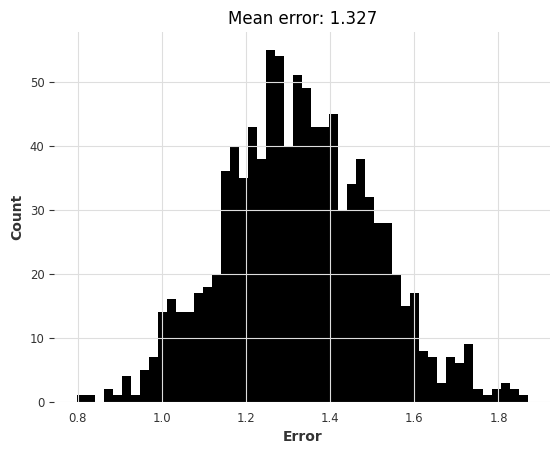

In [16]:
best_tide = TiDEModel.load_from_checkpoint(model_name='TiDE_model', best=True)
preds_tide = best_tide.predict(
                    series            = train,
                    past_covariates   = past_cov,
                    future_covariates = future_cov,
                    n                 = val[0].n_timesteps
                )

maes_tide = eval_forecasts(preds_tide, val, mae, plot=True)

In [ ]:
from darts.metrics import mae

# test_series, pred_series 는 각자 List[TimeSeries] (multivariate) 라고 가정
val_demand = [ ts.univariate_component('demand') for ts in val ]
pred_demand = [ ts.univariate_component('demand') for ts in preds_tide ]

maes_tide = eval_forecasts(pred_demand, val_demand, mae, plot=True)
# errors = mae(test_demand, pred_demand)
# print("Demand MAE:", errors)

# TFT

In [9]:
# PyTorch Lightning Trainer arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 50,
    "min_delta": 1e-3,
    "mode": "min",
}

pl_trainer_kwargs = {
    "max_epochs": 200,
    "accelerator": "gpu", # uncomment for gpu use
    "callbacks": [EarlyStopping(**early_stopping_args)],
    "enable_progress_bar":True
}

common_model_args = {
    "output_chunk_length": 1,
    "input_chunk_length": 150,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 128,
    "random_state": 42,
}

In [10]:
encoders = {
    "position": {"past": ["relative"], "future": ["relative"]},
    "transformer": Scaler(),
}

best_hp = {
 'optimizer_kwargs': {'lr':0.00005},
 'loss_fn': MAELoss(),
 'use_reversible_instance_norm': True,
 'add_encoders':encoders,
 }

In [11]:
past_cov = None if not past_cov else past_cov

start = time.time()
## COMMENT TO LOAD PRE-TRAINED MODEL
fit_mixed_covariates_model(
    model_cls = TFTModel,
    common_model_args = common_model_args,
    specific_model_args = best_hp,
    model_name = 'TFT_model',
    past_cov = past_cov,
    future_cov = future_cov,
    train_series = train,
    val_series = val,
)
time_tft = time.time() - start

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX PRO 6000 Blackwell Workstation Edition') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | MAELoss                          | 0      | train
1  | train_criterion                   | MAELoss                          | 0      | train
2  | val_criterion                     | MAELoss                          | 0    

Epoch 11:  21%|██        | 2134/10243 [15:00<56:59,  2.37it/s, train_loss=1.420, val_loss=0.977]   


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [12]:
best_tft = TFTModel.load_from_checkpoint(model_name='TFT_model', best=True)
preds_tft = best_tft.predict(
                    series            = train_val,
                    past_covariates   = past_cov,
                    future_covariates = future_cov,
                    n                 = test[0].n_timesteps
                )

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [07:37<00:00,  0.02it/s]


In [13]:
from tqdm import tqdm

group_cols = ["sku","city"]  # 예시
groups_df = (
    dataset
    .loc[:, group_cols]
    .drop_duplicates()
    .sort_values(by=group_cols)   # from_group_dataframe 도 내부적으로 정렬하므로
    .reset_index(drop=True)
)

result = []
for i in tqdm(range(len(groups_df))):
    group_id = groups_df.iloc[i]
    
    pred = preds_tft[i].to_dataframe()
    pred = pred.reset_index()
    pred = pred.rename(columns={"index": "date"})
    pred = pred.drop(columns=['discount_pct'])
    # pred['demand'] = np.exp(pred['demand'])
    
    for j in range(len(pred)):
        result.append({
            "sku":  group_id["sku"],
            "city": group_id["city"],
            "date": pred['date'][j],
            "mean": pred['demand'][j],
        })

result_df = pd.DataFrame(result)
result_df['mean'] = np.expm1(result_df['mean'])
result_df['mean'] = result_df['mean'].round().astype(int)
result_df['date'] = pd.to_datetime(result_df['date'])
sub = pd.read_csv("extracted_contents/data/forecast_submission_template.csv", parse_dates=["date"])
sub.drop(columns=['mean'], inplace=True)
sub = sub.merge(result_df, on=['sku', 'city', 'date'], how='left')
sub.to_csv("forecast_submission_template.csv", index=False)

100%|██████████| 1000/1000 [00:08<00:00, 121.48it/s]
